In [1]:
import torch
import torchvision
from torchvision.models import vgg11, VGG11_Weights
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import time

In [2]:
def get_data_loader(input_dir='datasets/inputs/', batch_size=1, resize=0) -> torch.utils.data.DataLoader:
    """Creates dataloader for networks from PyTorch's Model Zoo.
    Data loader uses mean and standard deviation for ImageNet.
    Args:
        config: Argparse namespace object.
    Returns:
        Data loader object.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transforms = []

    if resize:

        transforms += [
            torchvision.transforms.Resize(size=int(1.1 * resize)),
            torchvision.transforms.CenterCrop(size=resize),
        ]

    transforms += [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std),
    ]

    transform = torchvision.transforms.Compose(transforms=transforms)
    dataset = torchvision.datasets.ImageFolder(root=input_dir, transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    return data_loader

In [3]:
data_loader = get_data_loader()

In [4]:
from models import LRPModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def plot_relevance_scores(
    x: torch.tensor, r: torch.tensor, name: str,) -> None:
    """Plots results from layer-wise relevance propagation next to original image.
    Method currently accepts only a batch size of one.
    Args:
        x: Original image.
        r: Relevance scores for original image.
        name: Image name.
    """
    max_fig_size = 20

    _, _, img_height, img_width = x.shape
    max_dim = max(img_height, img_width)
    fig_height, fig_width = (
        max_fig_size * img_height / max_dim,
        max_fig_size * img_width / max_dim,
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, fig_height))

    x = x[0].squeeze().permute(1, 2, 0).detach().cpu()
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    axes[0].imshow(x)
    axes[0].set_axis_off()

    r_min = r.min()
    r_max = r.max()
    r = (r - r_min) / (r_max - r_min)
    axes[1].imshow(r, cmap="afmhot")
    axes[1].set_axis_off()

    fig.tight_layout()
    plt.show()

In [6]:
model = vgg11(weights=VGG11_Weights.DEFAULT)
model.to(device)
lrp_model = LRPModel(model=model, top_k=0.02)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /home/lnhutnam/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

0.50 FPS


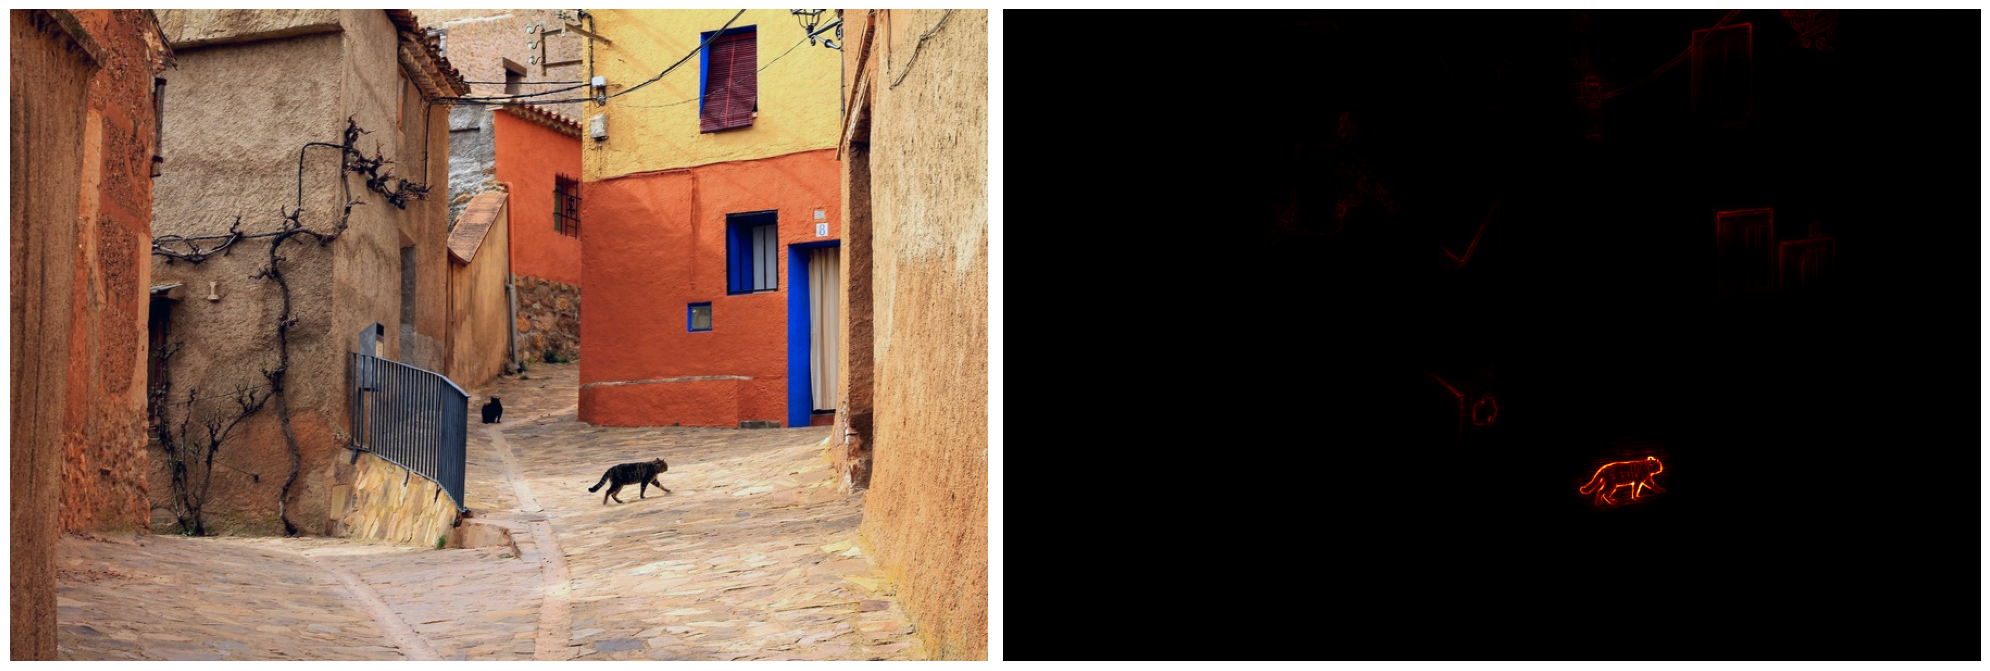

2.20 FPS


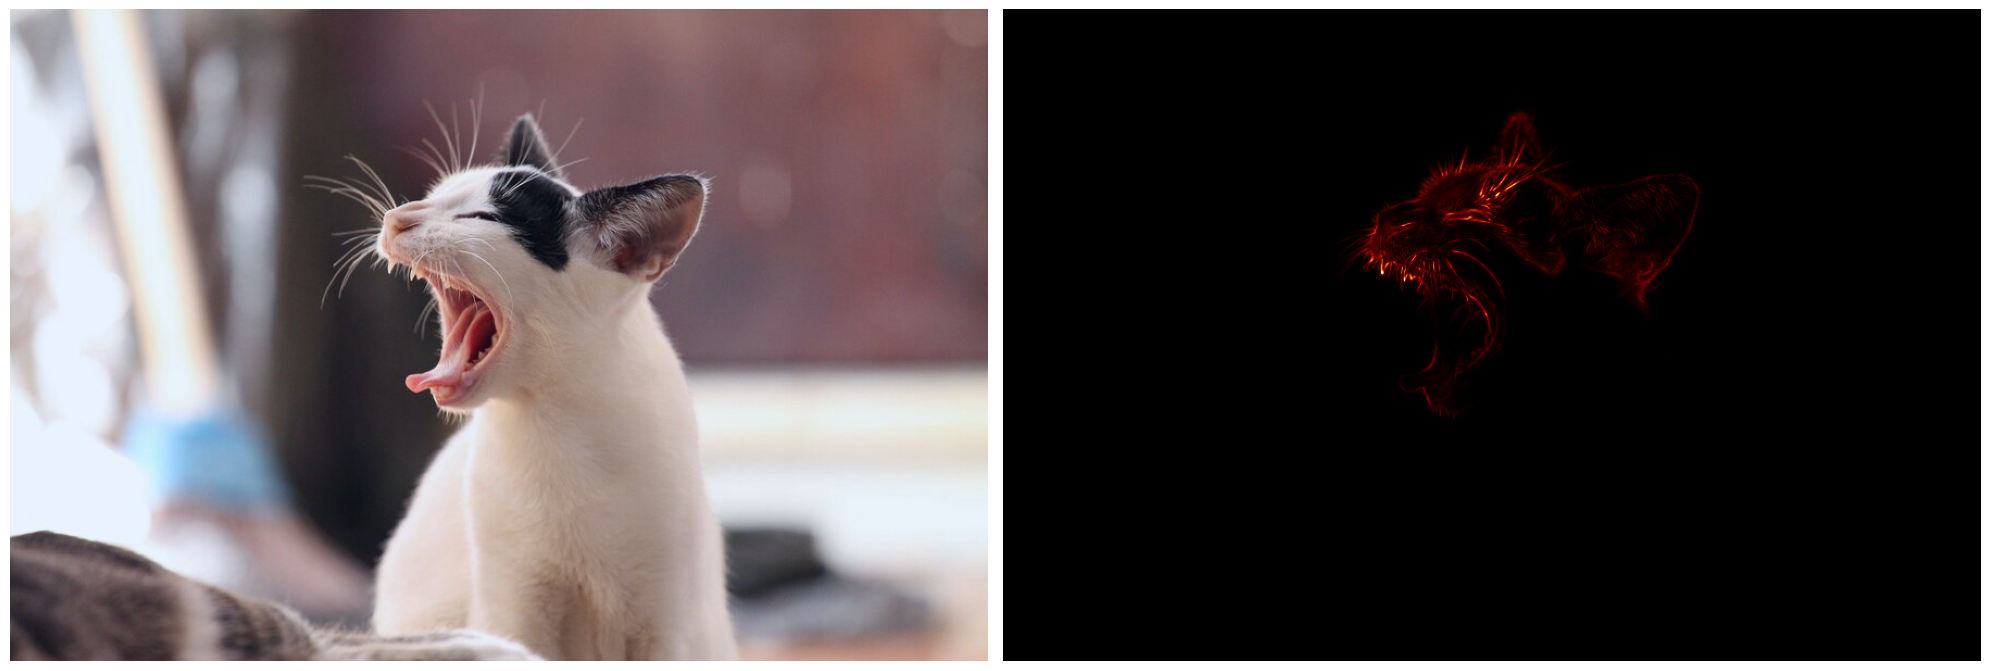

2.19 FPS


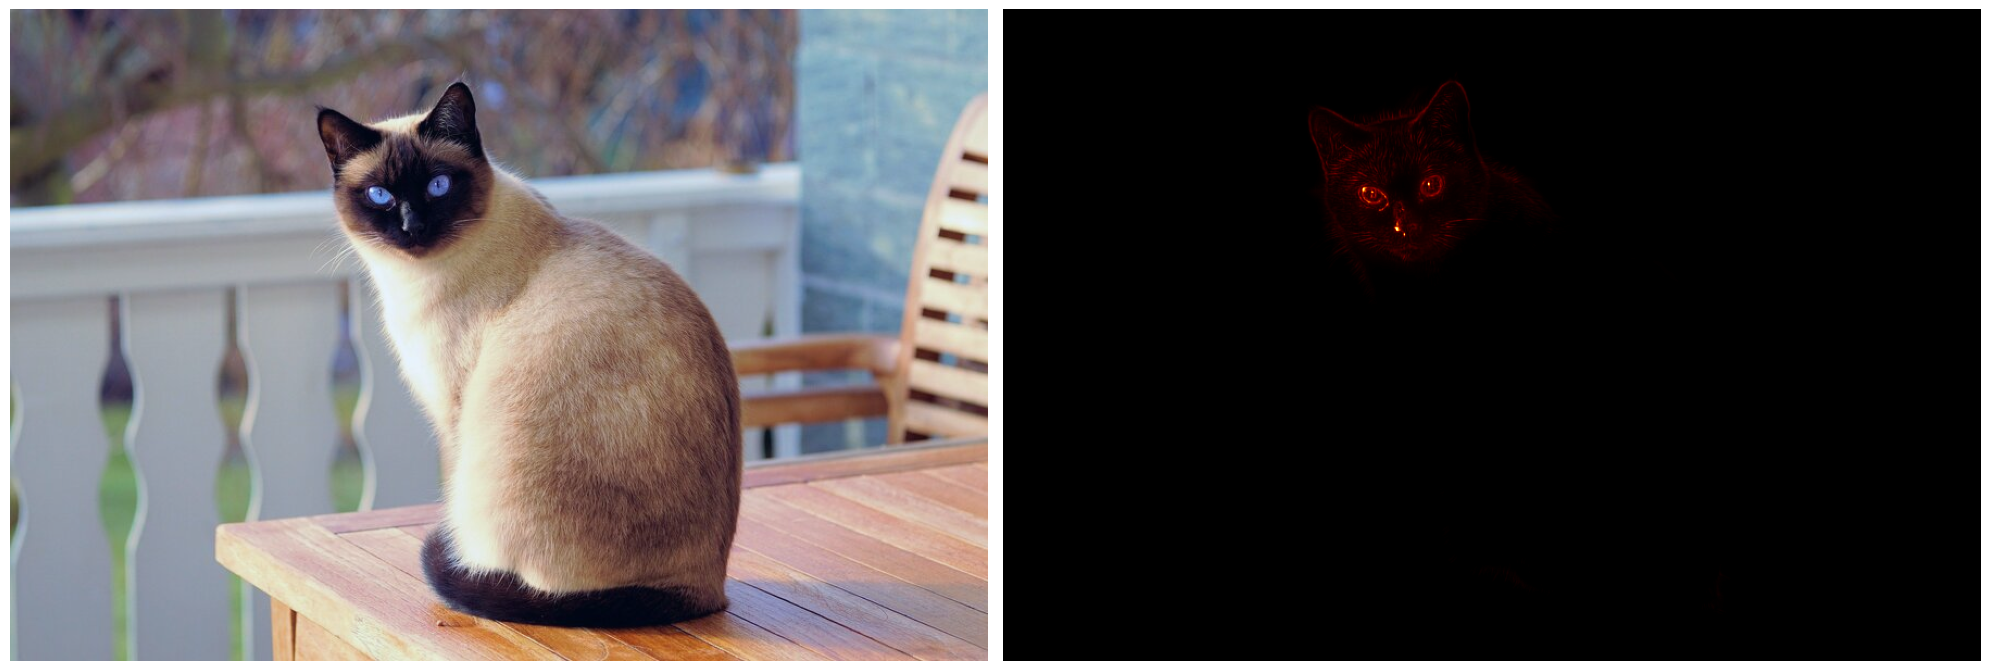

2.19 FPS


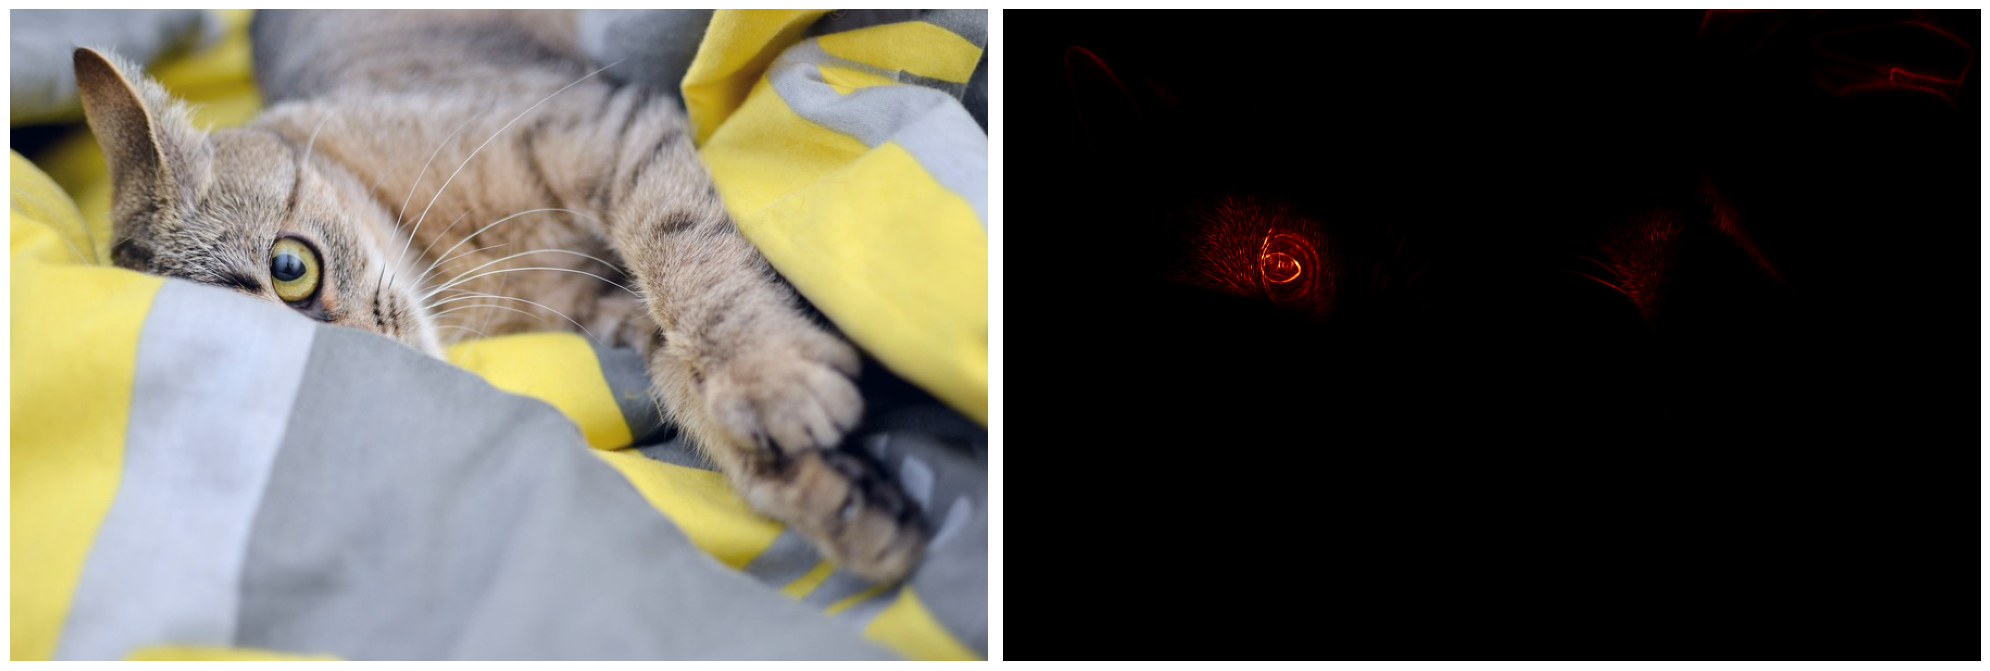

2.20 FPS


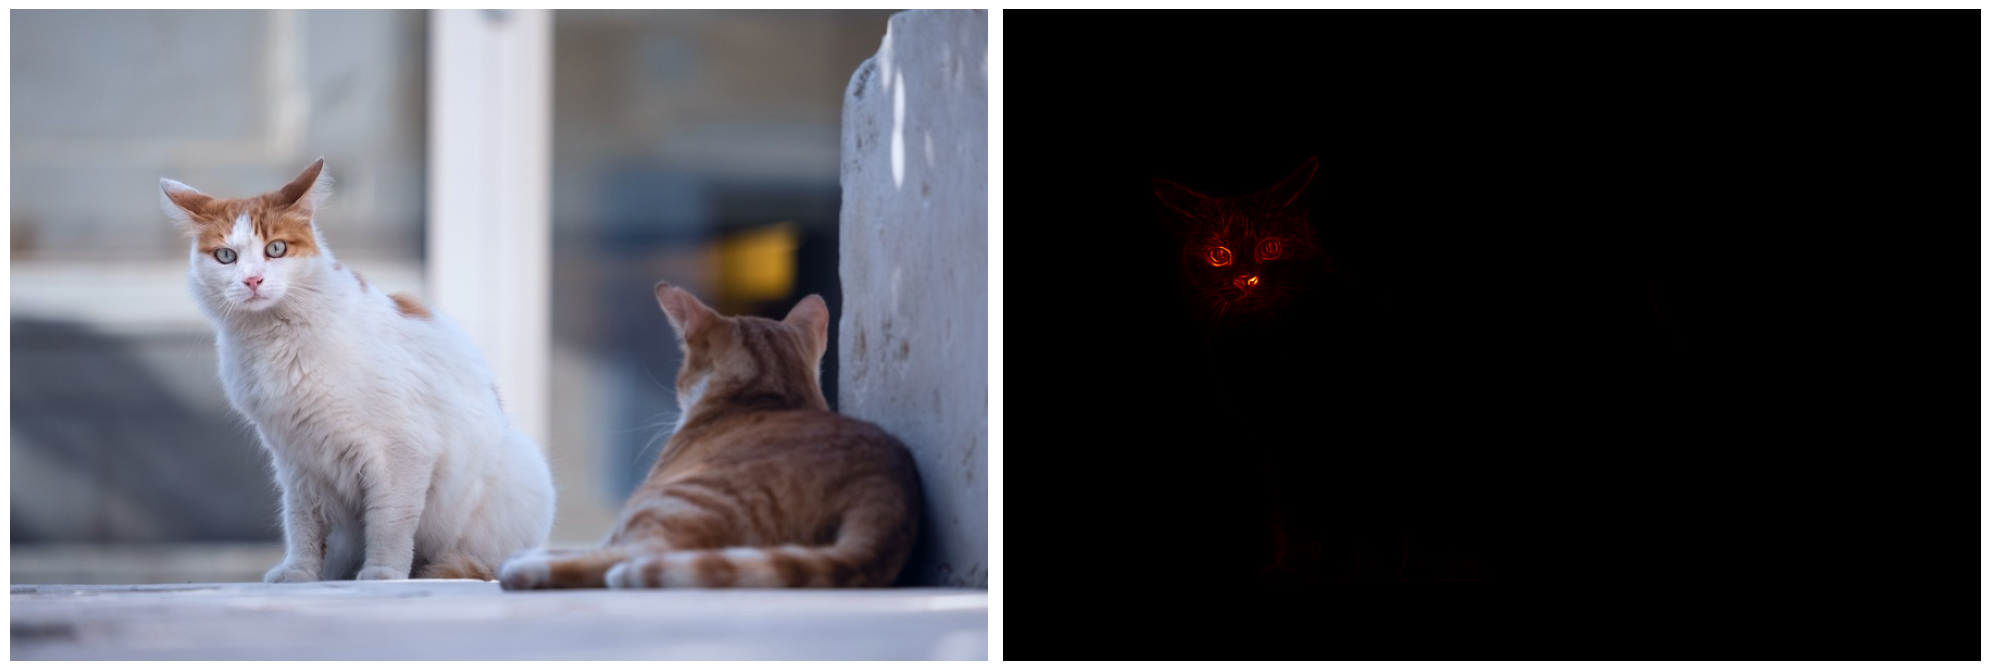

In [7]:
for i, (x, y) in enumerate(data_loader):
    if i == 5:
        break
    x = x.to(device)
    # y = y.to(device)  # here not used as method is unsupervised.
    t0 = time.time()
    r = lrp_model.forward(x)
    print("{time:.2f} FPS".format(time=(1.0 / (time.time() - t0))))
    plot_relevance_scores(x=x, r=r, name=str(i))